In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
signdata = pd.read_csv('/Users/emilkoch/Library/Mobile Documents/com~apple~CloudDocs/Data Files/signdata.csv', encoding='latin-1')

In [3]:
# Separate target variable from features
X = signdata.drop(columns=['SignBankEnglishTranslations'])  # Features

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['List', 'Item', 'EnglishWF(lg10)', 'SignFrequency(M)', 'SignFrequency(SD)', 'SignFrequency(Z)', 'SignFrequency(N)', 'Unknown', 'SignFrequency(M-Native)', 'SignFrequency(SD-Native)', 'SignFreq(Z-native)', 'SignFrequency(N-Native)', 'Unknown(Native)', 'SignFrequency(M-Nonnative)', 'SignFrequency(SD-Nonnative)', 'SignFrequency(N-Nonnative)', 'SignFreq(Z-Nonnative)', 'Unknown(Nonnative)', 'DominantTranslationAgreement', 'DominantTranslationAgreement(Native)', 'DominantTranslationAgreement(Nonnative)', 'Iconicity(M)', 'Iconicity(SD)', 'Iconicity(Z)', 'Iconicity(N)', 'D.Iconicity(M)', 'D.Iconicity(SD)', 'D.Iconicity(N)', 'D.Iconicity(Z)', 'D.Iconicity(M-native)', 'D.Iconicity(SD-native)', 'D.Iconicity(Z-native)', 'D.Iconicity(N-native)', 'GuessConsistency', 'GuessAccuracy', 'Transparency(M)', 'Transparency SD', 'Transparency Z', 'Initialized.2.0', 'FingerspelledLoanSign.2.0', 'Compound.2.0', 'NumberOfMorphemes.2.0', 'SignOnset(ms)', 'SignOffset(ms)', 'SignDuration(ms)', '

In [4]:
# Preprocessing for numerical features
numerical_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Copy numerical columns
X_numerical = X[numerical_cols].copy()
print(len(X_numerical))
print(len(numerical_cols))
print(X_numerical.head())
print(X_numerical.isnull().sum())

2723
129
   List  Item  EnglishWF(lg10)  SignFrequency(M)  SignFrequency(SD)  \
0     1     2            3.521             5.143              2.081   
1     1     3            4.645             6.032              1.516   
2     1     4            2.600             4.429              1.720   
3     1     5            2.928             2.621              1.720   
4     1     8            3.041             1.579              0.838   

   SignFrequency(Z)  SignFrequency(N)  Unknown  SignFrequency(M-Native)  \
0             0.621                21    0.000                    5.167   
1             1.068                31    0.000                    6.111   
2             0.232                21    0.000                    4.167   
3            -0.753                29    0.065                    2.000   
4            -1.198                19    0.095                    1.455   

   SignFrequency(SD-Native)  ...  ThumbContact.2.0Frequency  \
0                     2.167  ...                  

In [5]:
columns_to_drop = [
    'UlnarRotationM4.2.0', 'FlexionChangeM5.2.0', 'SpreadChangeM5.2.0',
    'SignTypeM5.2.0', 'MovementM5.2.0', 'RepeatedMovementM5.2.0',
    'MajorLocationM5.2.0', 'MinorLocationM5.2.0', 'SecondMinorLocationM5.2.0',
    'ContactM5.2.0', 'NonDominantHandshapeM5.2.0', 'UlnarRotationM5.2.0',
    'FlexionChangeM6.2.0', 'SpreadChangeM6.2.0', 'SignTypeM6.2.0',
    'MovementM6.2.0', 'RepeatedMovementM6.2.0', 'MajorLocationM6.2.0',
    'MinorLocationM6.2.0', 'SecondMinorLocationM6.2.0', 'ContactM6.2.0',
    'NonDominantHandshapeM6.2.0', 'UlnarRotationM6.2.0'
]
# Select columns not in columns_to_drop from X_numerical
X_numerical_2 = X_numerical.drop(columns=columns_to_drop)
# Impute missing values and scaling
imputer = SimpleImputer(strategy='median')
X_numerical_imputed = imputer.fit_transform(X_numerical_2) 
scaler = StandardScaler()
X_numerical_scaled  = scaler.fit_transform(X_numerical_imputed)  

In [6]:
from sklearn.compose import make_column_selector as selector

# Check for missing values in the DataFrame
missing_values = X[categorical_cols].isnull().sum()
print("Missing values in categorical columns:")
print(missing_values)

# If there are missing values, handle them before preprocessing
if missing_values.sum() > 0:
    # Handle missing values using SimpleImputer with the most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = imputer.fit_transform(X[categorical_cols])

# Define the pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # One-hot encode categorical features and produce a dense array
])

# Apply the pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Include non-categorical columns
)

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)

# Convert the encoded array to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded)
print(X_encoded_df.isna().sum())

Missing values in categorical columns:
EntryID                     0
LemmaID                     0
Code                        0
Batch                       0
DominantTranslation      2083
                         ... 
SignBankAnnotationID      720
SignBankLemmaID           734
SignBankSemanticField    1846
InCDI                       0
CDISemanticCategory      2155
Length: 61, dtype: int64
0           0
1           0
2           0
3           0
4           0
         ... 
14078       0
14079      26
14080     734
14081    2190
14082    2190
Length: 14083, dtype: int64


In [7]:
# Check data types of all columns in X_encoded_df
data_types = X_encoded_df.dtypes

# Check if any column has a non-numeric data type
non_numeric_columns = data_types[data_types != 'float64'][data_types != 'int64']

# Print any non-numeric columns
if not non_numeric_columns.empty:
    print("Non-numeric columns found after one-hot encoding:")
    print(non_numeric_columns)
else:
    print("All columns are numeric after one-hot encoding.")


All columns are numeric after one-hot encoding.


In [8]:
# Concatenate numerical and encoded categorical columns
X_processed = pd.concat([pd.DataFrame(X_numerical_scaled), X_encoded_df], axis=1)

# Check for missing values in the processed DataFrame
missing_values_processed = X_processed.isnull().sum()
print("Missing values in processed DataFrame:")
print(missing_values_processed)

# Replace NaN values with 0
X_processed.fillna(0, inplace=True)
print(X_processed.isnull().sum())

Missing values in processed DataFrame:
0           0
1           0
2           0
3           0
4           0
         ... 
14078       0
14079      26
14080     734
14081    2190
14082    2190
Length: 14189, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
14078    0
14079    0
14080    0
14081    0
14082    0
Length: 14189, dtype: int64


In [9]:
# Drop NaN values from the target variable
y_cleaned = signdata['SignBankEnglishTranslations'].dropna()

# Index X_processed with the same indices as y_cleaned
X_processed_cleaned = X_processed.loc[y_cleaned.index]

print("Shape of X_processed:", X_processed_cleaned.shape)
print("Shape of y_encoded:", y_cleaned.shape)  # Adjusted to use y_cleaned.shape for consistency

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(y_cleaned)

# Check for NaN values in the target variable after dropping
nan_count_after_drop = y_cleaned.isnull().sum()
print("Number of NaN values in 'SignBankEnglishTranslations' column after dropping:", nan_count_after_drop)
# Check for NaN values in X_processed_cleaned after dropping NaN values from the target variable
nan_count_in_processed = X_processed_cleaned.isna().sum()
print('Number of NaN values in X_processed_cleaned:', nan_count_in_processed)

Shape of X_processed: (1984, 14189)
Shape of y_encoded: (1984,)
Number of NaN values in 'SignBankEnglishTranslations' column after dropping: 0
Number of NaN values in X_processed_cleaned: 0        0
1        0
2        0
3        0
4        0
        ..
14078    0
14079    0
14080    0
14081    0
14082    0
Length: 14189, dtype: int64


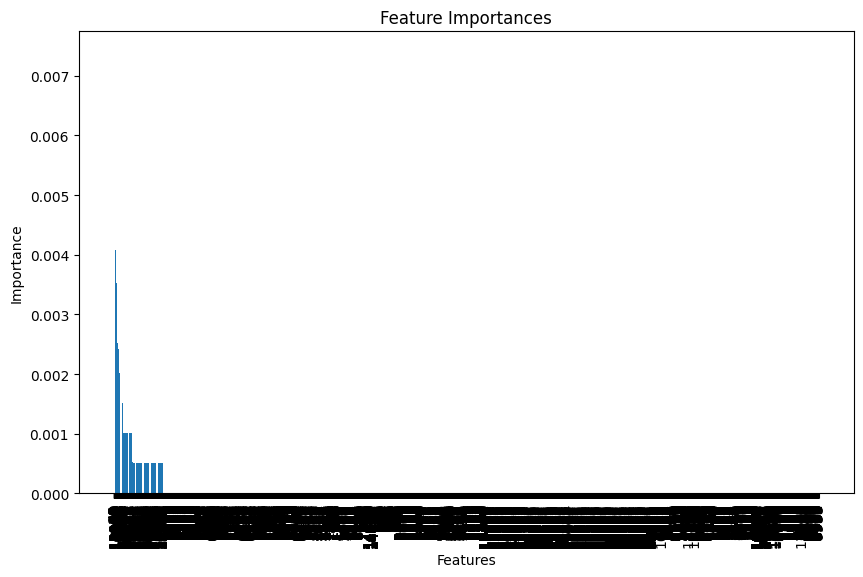

In [49]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier()

# Fit the decision tree model to the data
tree_clf.fit(X_processed_cleaned, y_encoded)

# Extract feature importances
feature_importances = tree_clf.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_processed_cleaned .shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X_processed_cleaned .shape[1]), X_processed_cleaned.columns[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Calculate Pearson correlation coefficient (linear)
pearson_correlation = np.abs(np.corrcoef(X_processed_cleaned.T, y_encoded)[0, 1:])

# Select features with correlation coefficients greater than or equal to 0.05
selected_features_indices = np.where(pearson_correlation >= 0.05)[0]

# Print selected features
print("Selected Features (Pearson Correlation >= 0.05):")
for i in selected_features_indices:
    print(f"Feature {i}: {pearson_correlation[i]}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: divide by zero encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected Features (Pearson Correlation >= 0.05):
Feature 5: 0.19358379096080156
Feature 10: 0.07649339411084341
Feature 12: 0.0599643650734562
Feature 14: 0.17796987811371062
Feature 21: 0.06297584642516729
Feature 23: 0.18371298899581665
Feature 9931: 0.057672026012484646
Feature 10093: 0.053010177405571755
Feature 10108: 0.0546484555679523
Feature 10109: 0.05988097669587771
Feature 10192: 0.06144404892686862
Feature 10223: 0.054648455567952184
Feature 14059: 1.0
Feature 14065: 0.19358379096080186
Feature 14070: 0.07649339411084287
Feature 14072: 0.05996436507345614
Feature 14074: 0.17796987811370885
Feature 14081: 0.05811774221201273
Feature 14083: 0.17451765333467573


In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_cleaned, y_encoded, test_size=0.2, random_state=42)

# Initialize the ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Fit the model to your training data
et_classifier.fit(X_train, y_train)

# Get feature importances
importances = et_classifier.feature_importances_

# Print the feature importances
print("Feature Importances:")
for i, importance in enumerate(importances):
    print(f"Feature {i}: {importance}")


Feature Importances:
Feature 0: 0.004565478965594654
Feature 1: 0.005973365719543002
Feature 2: 0.0063335792289062505
Feature 3: 0.00603122474444478
Feature 4: 0.00613335596477782
Feature 5: 0.005991957743444009
Feature 6: 0.005366069697664998
Feature 7: 0.0030177718007532205
Feature 8: 0.006043229718459517
Feature 9: 0.0059943420274468995
Feature 10: 0.005950842702617453
Feature 11: 0.005089453138431095
Feature 12: 0.002505572757298882
Feature 13: 0.005758265369209827
Feature 14: 0.005734334831575208
Feature 15: 0.00497066364815577
Feature 16: 0.006042635875160868
Feature 17: 0.002413661565358928
Feature 18: 0.002961586766777099
Feature 19: 0.0025720985961997745
Feature 20: 0.0027377359268449136
Feature 21: 0.006279459679387323
Feature 22: 0.006006368935598187
Feature 23: 0.006243911620621285
Feature 24: 0.005880898802327311
Feature 25: 0.003988215189962114
Feature 26: 0.003948692377298243
Feature 27: 0.0031840007574786026
Feature 28: 0.004156221075152103
Feature 29: 0.004074019652632

In [18]:
# Filter importances >= 0.05
important_features = [importance for importance in importances if importance >= 0.005]

# Print the important features
print("Important Features:")
for i, importance in enumerate(important_features):
    print(f"Feature {i}: {importance}")

Important Features:
Feature 0: 0.005973365719543002
Feature 1: 0.0063335792289062505
Feature 2: 0.00603122474444478
Feature 3: 0.00613335596477782
Feature 4: 0.005991957743444009
Feature 5: 0.005366069697664998
Feature 6: 0.006043229718459517
Feature 7: 0.0059943420274468995
Feature 8: 0.005950842702617453
Feature 9: 0.005089453138431095
Feature 10: 0.005758265369209827
Feature 11: 0.005734334831575208
Feature 12: 0.006042635875160868
Feature 13: 0.006279459679387323
Feature 14: 0.006006368935598187
Feature 15: 0.006243911620621285
Feature 16: 0.005880898802327311
Feature 17: 0.005868135120701018
Feature 18: 0.006142217829404179
Feature 19: 0.005933615664999975
Feature 20: 0.005843955828270534
Feature 21: 0.005681482708363686
Feature 22: 0.005454068521684655
Feature 23: 0.006129903486185363
Feature 24: 0.006189773711365599
Feature 25: 0.006168136816706561
Feature 26: 0.006205340623852129
Feature 27: 0.006431046498053239
Feature 28: 0.006277587461969509
Feature 29: 0.0060634170668499385

In [21]:
# Combine important_features and selected_features_indices
combined_features_indices = set(selected_features_indices).union(set(np.where(np.array(importances) >= 0.05)[0]))

# Filter out any importance values that accidentally got included
combined_features_indices = {idx for idx in combined_features_indices if idx < len(importances)}

# Print combined selected features
print("Combined Selected Features:")
for i in combined_features_indices:
    print(f"Feature {i}: {importances[i]}")

Combined Selected Features:
Feature 14081: 0.006331994472830065
Feature 14083: 0.006218499636101485
Feature 5: 0.005991957743444009
Feature 10: 0.005950842702617453
Feature 12: 0.002505572757298882
Feature 14: 0.005734334831575208
Feature 21: 0.006279459679387323
Feature 23: 0.006243911620621285
Feature 9931: 0.00022157689573883412
Feature 10192: 0.00023775028877907805
Feature 14059: 0.00010721936050818906
Feature 10093: 0.00010087979479599527
Feature 10223: 0.00013556033081061413
Feature 14065: 0.0060634170668499385
Feature 14070: 0.006140353654395336
Feature 14072: 0.0028139898658107194
Feature 14074: 0.005506669560968855
Feature 10108: 1.2611543018712285e-05
Feature 10109: 2.5223086037424576e-05


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Extract the selected features from X_processed_cleaned
X_selected = X_processed_cleaned[:, list(combined_features_indices)]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = rf_classifier.score(X_test, y_test)
print("Random Forest Accuracy:", accuracy)

InvalidIndexError: (slice(None, None, None), [14081, 14083, 5, 10, 12, 14, 21, 23, 9931, 10192, 14059, 10093, 10223, 14065, 14070, 14072, 14074, 10108, 10109])